# Time Series

## Imports

In [36]:
%config InlineBackend.figure_format="retina"

In [37]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from numpy.typing import NDArray
from tensorflow_probability import distributions as tfd

## An overview of time series problems

Time series userful when there is:

- A trend
- Seasonality
- The current point infroms the next point—where
  noise or residuals are correlated
  
$$
y_t = \text{Trend}_t + \text{Seasonality}_t + \text{Residuals}_t
$$

## Time series analysis as a regression problem

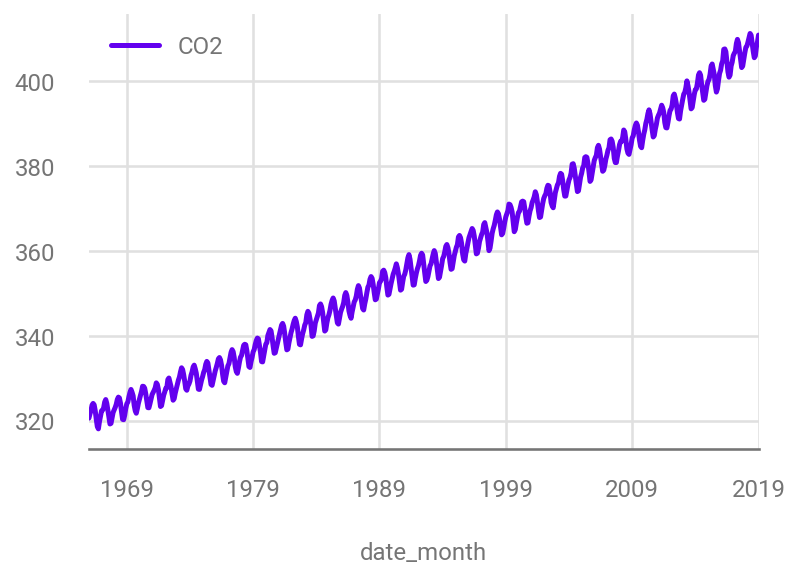

In [38]:
co2_by_month = (
    pd.read_csv(
        "https://raw.githubusercontent.com"
        "/BayesianModelingandComputationInPython/BookCode_Edition1/main"
        "/data/monthly_mauna_loa_co2.csv",
        parse_dates=["date_month"],
    )
    .set_index("date_month")
    .assign(CO2=lambda df: df["CO2"].astype("float32"))
)
num_forecast_steps = 12 * 10
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]
co2_by_month_testing_data = co2_by_month[-num_forecast_steps:]
co2_by_month.plot.line();

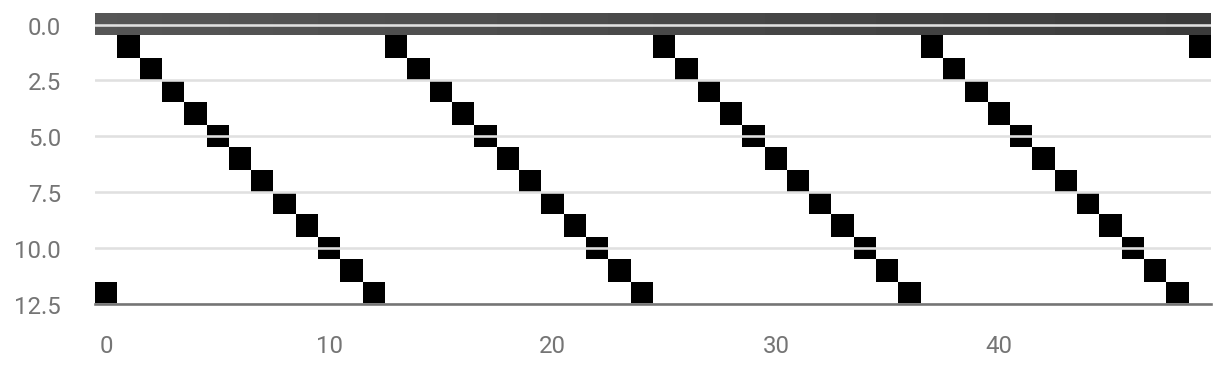

In [39]:
trend_all = np.linspace(0.0, 1.0, co2_by_month.shape[0])[..., None].astype("float32")
trend = trend_all[:-num_forecast_steps, :]
seasonality_all = pd.get_dummies(co2_by_month.index.month).to_numpy().astype("float32")
seasonality = seasonality_all[:-num_forecast_steps, :]
_, ax = plt.subplots(figsize=(10, 4))
X_subset = np.concatenate([trend, seasonality], axis=-1)[-50:]
ax.imshow(X_subset.T, cmap="Greys");

In [40]:
seasonality_all

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Typical cyclical information,
in order of resolution:

1. Second of the hour (1, 2, …, 60)
2. Hour of the day (1, 2, …, 24)
3. Day of the week (Monday, Tuesday, …, Sunday)
4. Day of the month(1, 2, …, 31)
5. Holiday effect (New year's, etc)
6. Month of the year (1, 2, …, 12)

Day of the week and month
are usually cloesly correlated with human activities—like
passenger numbers of public transportation.

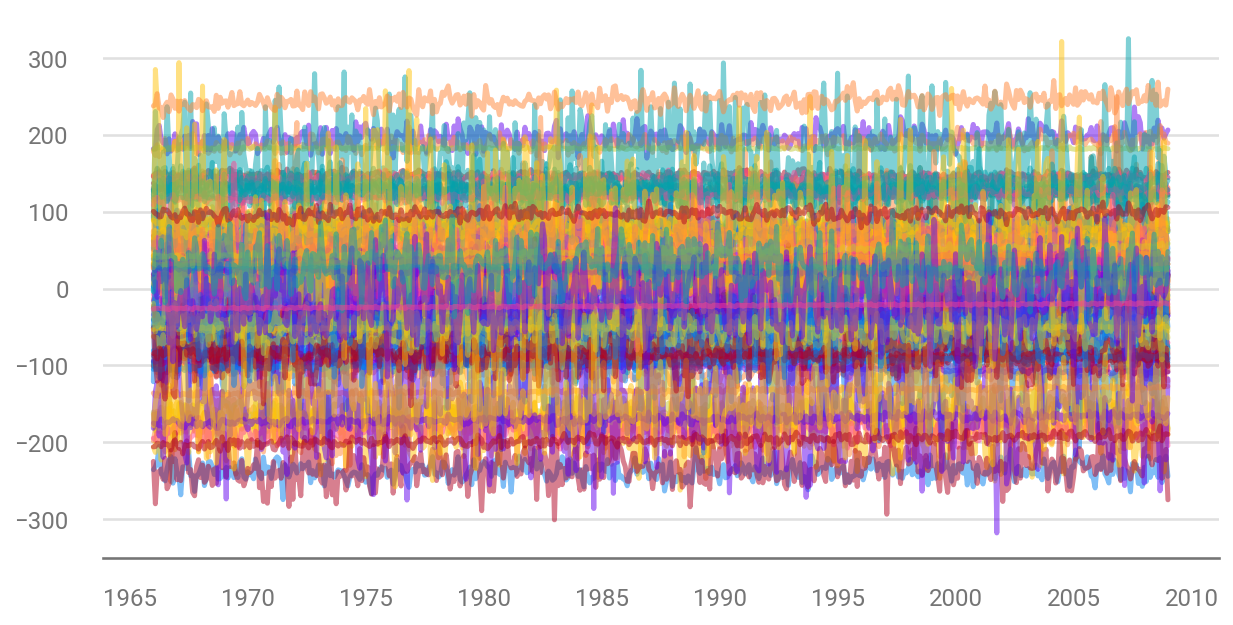

In [41]:
root = tfd.JointDistributionCoroutine.Root


@tfd.JointDistributionCoroutine
def ts_regression_model():
    intercept = yield root(tfd.Normal(0.0, 100.0, name="intercept"))
    trend_coeff = yield root(tfd.Normal(0.0, 10.0, name="trend_coeff"))
    seasonality_coeff = yield root(
        tfd.Sample(
            tfd.Normal(0.0, 1.0),
            sample_shape=seasonality.shape[-1],
            name="seasonality_coeff",
        )
    )
    noise = yield root(tfd.HalfCauchy(loc=0.0, scale=5.0, name="noise_sigma"))
    y_hat = (
        intercept[..., None]
        + tf.einsum("ij,...->...i", trend, trend_coeff)
        + tf.einsum("ij,...j->...i", seasonality, seasonality_coeff)
    )
    observed = yield tfd.Independent(
        tfd.Normal(y_hat, noise[..., None]),
        reinterpreted_batch_ndims=1,
        name="observed",
    )


prior_samples = ts_regression_model.sample(100)
prior_predictive_timeseries = prior_samples.observed
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    co2_by_month.index[:-num_forecast_steps],
    tf.transpose(prior_predictive_timeseries),
    alpha=0.5,
);

Each line plot is one simulated time series for prior predictive.
Prediction has a wide range due to uniformative prior.

In [59]:
run_mcmc?

Signature:      
run_mcmc(
    n_draws,
    joint_dist,
    *,
    n_chains=64,
    num_adaptation_steps=500,
    current_state=None,
    init_step_size=None,
    dual_averaging_kwargs=None,
    max_tree_depth=10,
    max_energy_diff=500.0,
    unrolled_leapfrog_steps=1,
    parallel_iterations=10,
    trace_fn=<function default_nuts_trace_fn at 0x13eabb550>,
    return_final_kernel_results=False,
    discard_tuning=True,
    chain_axis_names=None,
    seed=None,
    **pins,
)
Call signature:  run_mcmc(*args, **kwds)
Type:            Function
String form:     <tensorflow.python.eager.def_function.Function object at 0x17e4df2e0>
File:            ~/Library/Caches/pypoetry/virtualenvs/bayesian-modeling-computation-python-XD4SKI4--py3.9/lib/python3.9/site-packages/tensorflow_probability/python/experimental/mcmc/windowed_sampling.py
Docstring:      
Adapt and sample from a joint distribution using NUTS, conditioned on pins.

Step size is tuned using a dual-averaging adaptation, and the kern

2022-05-31 19:58:32.486301: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. sanitize_seed/seed
2022-05-31 19:58:32.633300: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


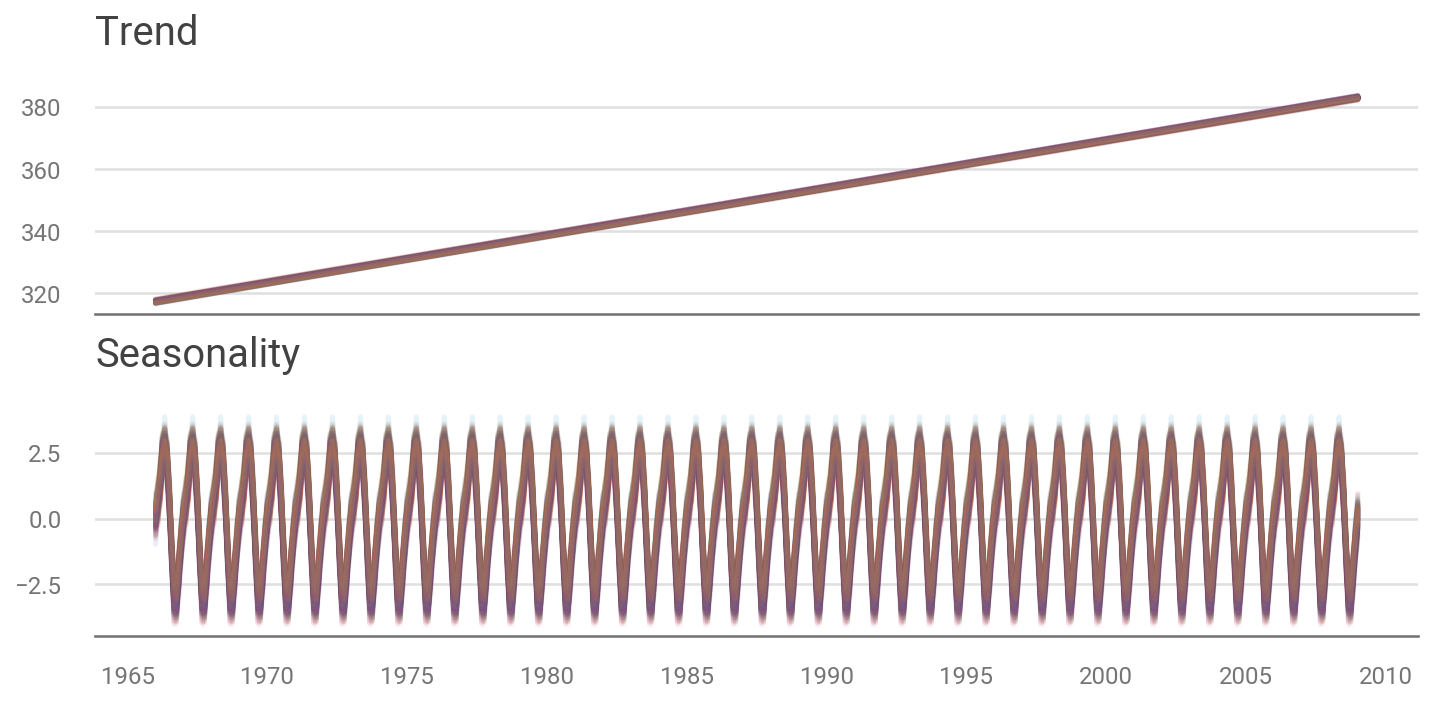

In [42]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts, autograph=False, jit_compile=True
)
mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    ts_regression_model,
    n_chains=4,
    num_adaptation_steps=1_000,
    observed=co2_by_month_training_data["CO2"].values[None, ...],
)
regression_idata = az.from_dict(
    posterior={
        k: np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)
nchains = regression_idata.posterior.dims["chain"]
trend_posterior = mcmc_samples.intercept + tf.einsum(
    "ij,...->i...", trend_all, mcmc_samples.trend_coeff
)
seasonality_posterior = tf.einsum(
    "ij,...j->i...", seasonality_all, mcmc_samples.seasonality_coeff
)
y_hat = trend_posterior + seasonality_posterior
posterior_predictive_dist = tfd.Normal(y_hat, mcmc_samples.noise_sigma)
posterior_predictive_samples = posterior_predictive_dist.sample()

_, (top_ax, bottom_ax) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)
for i in range(nchains):
    top_ax.plot(
        co2_by_month.index[:-num_forecast_steps],
        trend_posterior[:-num_forecast_steps, -100:, i],
        alpha=0.05,
    )
    bottom_ax.plot(
        co2_by_month.index[:-num_forecast_steps],
        seasonality_posterior[:-num_forecast_steps, -100:, i],
        alpha=0.05,
    )
top_ax.set_title("Trend")
bottom_ax.set_title("Seasonality")
plt.tight_layout();

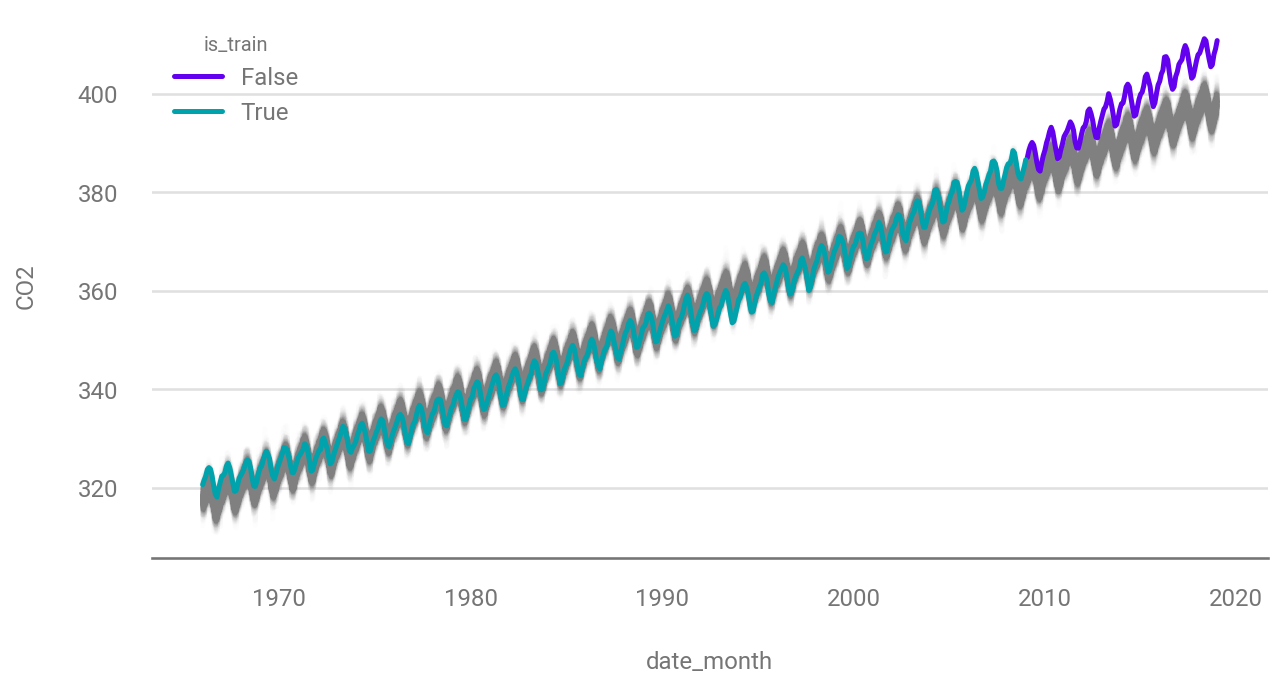

In [43]:
_, ax = plt.subplots(figsize=(10, 5))
sample_shape = posterior_predictive_samples.shape[1:]
ax.plot(
    co2_by_month.index,
    tf.reshape(posterior_predictive_samples, [-1, tf.math.reduce_prod(sample_shape)])[
        :, :500
    ],
    color="gray",
    alpha=0.01,
)
(
    co2_by_month.assign(
        is_train=lambda df: df.index.isin(co2_by_month.iloc[:-num_forecast_steps].index)
    )
    .reset_index()
    .pipe((sns.lineplot, "data"), x="date_month", y="CO2", hue="is_train", ax=ax)
);

Some problems

1. Linear trend does not perform well further into the future.
  Is consistently lower than reality.
2. The range of uncertainty is almost constant.
  We expect uncertainty to increase
  when we forecast further into the future.

### Design matrices for time series

Sesonaility components are usually sationary—the
means and covariances remain invariant across time—with
easy to estimate parameters.
Most time series involves desinging latent process that realistically captures the non-stationary trends.

One approach is using local linear processes
for the trend component.
It is a smooth trend that is linear within some range,
with an intercept and coefficient that changes—or
drifts—slowly
over the observed time span.
Prophet uses a semi-smooth step linear function to model the trend.
By allowing the slope to change at specific breakpoints,
we can genereate a trend line
that can caputre long-term trend much better
than a straight line.

$$
g(t) = (k + \mathbf{A}\delta) t + (m + \mathbf{A} \gamma)
$$

where $k$ is the global growth rate,
$\delta$ is a vector of rate adjustements at each point,
$m$ is the global intercept,
$\mathbf{A}$ is a matrix of shape $n_t$, $n_s$—where
$n_s$ is the number of change points.
At time $t$,
$\mathbf{A}$ accumulates the drift effect $\delta$ fo the slope.
$\gamma$ is set to $-s_j \times \delta_j$—where
$s_j$ is the time location of the $n_s$ change points.
A regularized prior—often
$\text{Laplace}$—is
chosen for $\delta$ to
express that we don't expect to see a sudden or large change in the slope.

In [44]:
n_changepoints = 8
n_tp = 500
t = np.linspace(0, 1, n_tp)
s = np.linspace(0, 1, n_changepoints + 2)[1:-1]
A = t[:, None] > s

k = 2.5
m = 40
rng = np.random.default_rng()
delta = rng.laplace(0.1, size=n_changepoints)
growth = (k + A @ delta) * t
offset = m + A @ (-s * delta)
trend = growth + offset

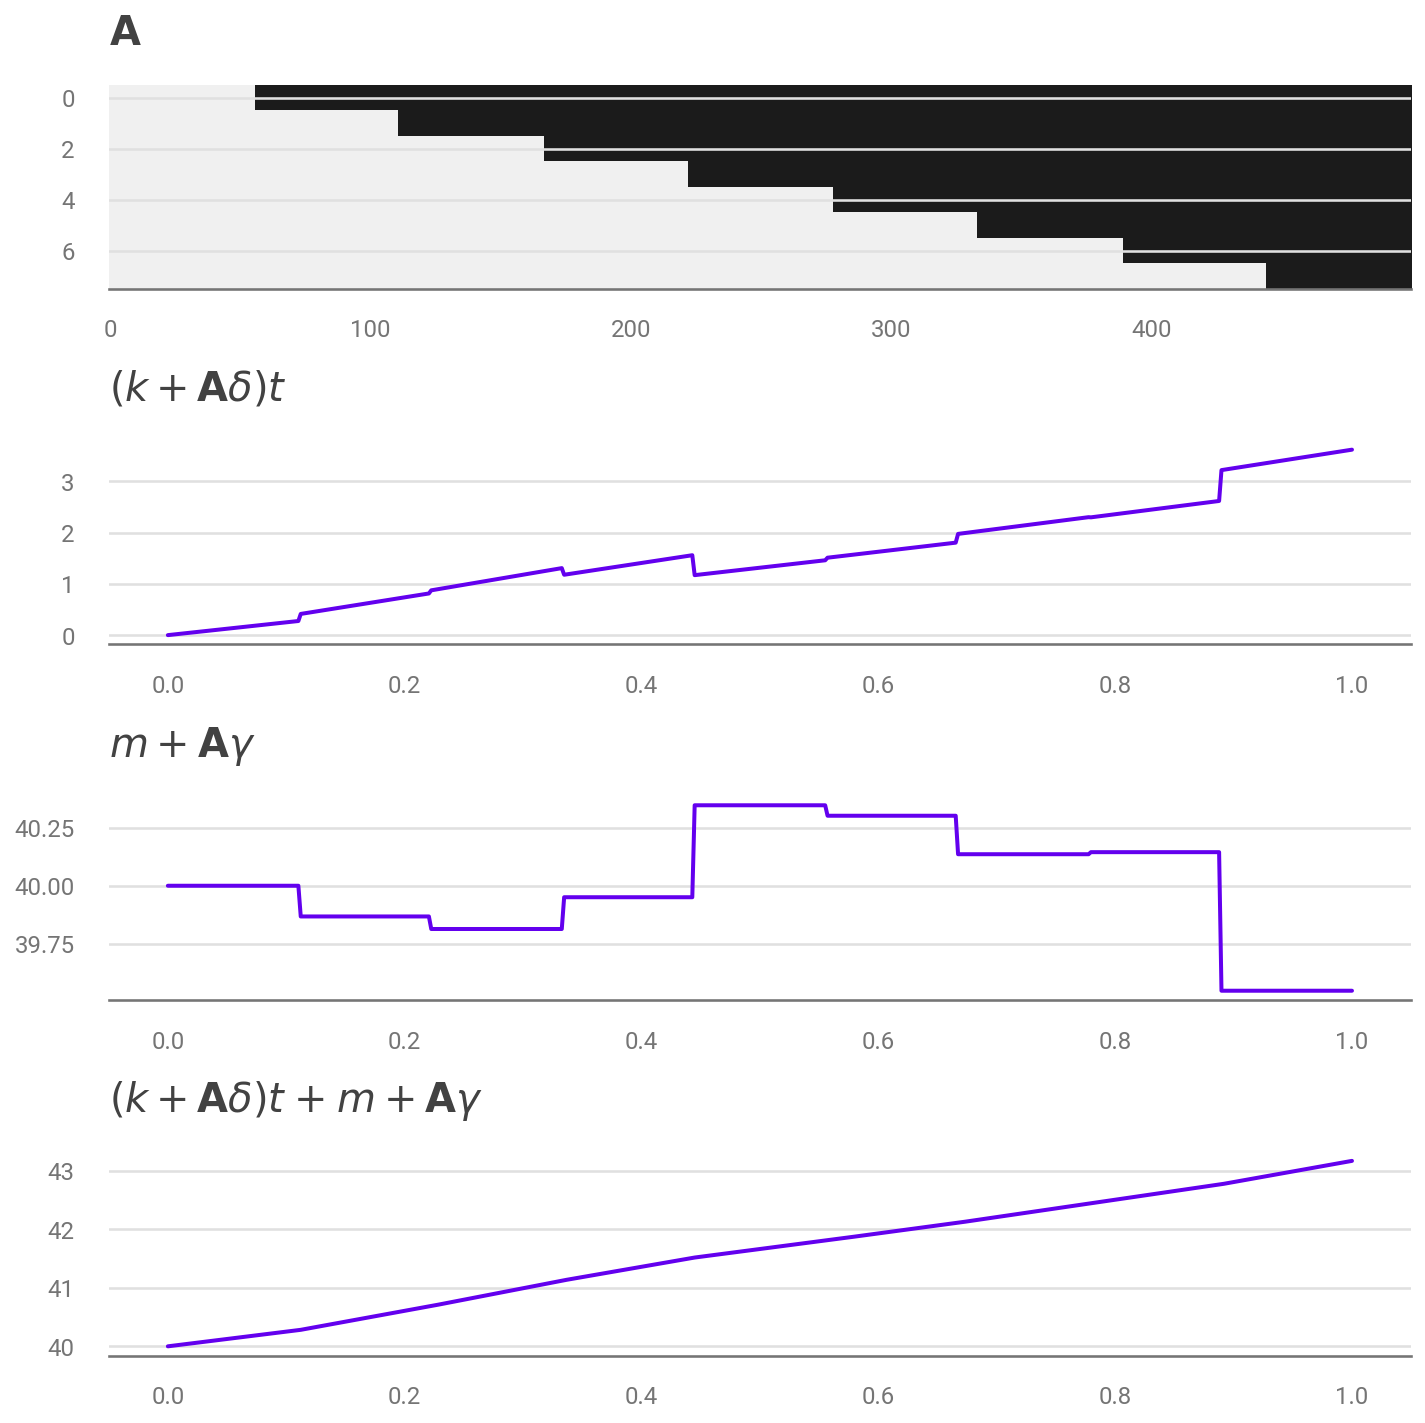

In [45]:
_, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize=(10, 10))
ax1.set_title(r"$\mathbf{A}$")
ax1.imshow(A.T, cmap="cet_gray_r", aspect="auto", interpolation="none")
growth_title = r"$(k + \mathbf{A}\delta) t$"
ax2.set_title(growth_title)
ax2.plot(t, growth, lw=2)
offset_title  = r"$m + \mathbf{A} \gamma$"
ax3.set_title(offset_title)
ax3.plot(t, offset, lw=2)
ax4.plot(t, trend, lw=2)
ax4.set_title(f"{growth_title} $+$ {offset_title}")
plt.tight_layout();

We usually specify how many change points there are
so $\mathbf{A}$ can be generated statically.
One approach is to specify more points than you beleive the time series actually displays,
and place a more spares prior $\delta$
to regulate the posterior towards 0.
Automatic changepoint detection is also possible.

### Basis functions and generalized additive model

Before we model seasinality component with a sparse matrix.
Another was is to use basis functions like B-spline,
or Fourier basis functions.
Basis functions can provide orthogonality.

Fourier basis functions are a collection of sin and cosine functions
that can be used for approximating arbitrary smooth seasonal effects:

$$
s(t) = \sum^N_{n=1} \left[a_n \text{cos}\left(\frac{2 \pi nt}{P} \right) + b_n \text{sin}\left(\frac{2 \pi nt}{P}\right) \right]
$$

where $P$ is the regular period the time series has
($P = 365.25$ for yearly or $P = 7$ for weekly).

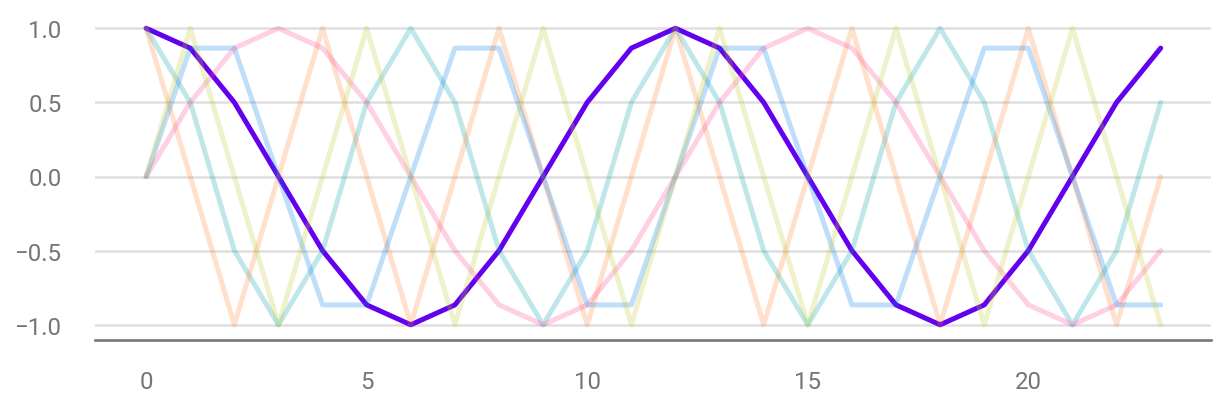

In [46]:
def gen_fourier_basis(
    t: NDArray[float], p: float = 365.25, n: int = 3
) -> NDArray[float]:
    x = 2 * np.pi * (np.arange(n) + 1) * t[:, None] / p
    return np.concatenate((np.cos(x), np.sin(x)), axis=1)


n_tp = 500
p = 12
t_monthly = np.asarray([i % p for i in range(n_tp)])
monthly_X = gen_fourier_basis(t_monthly, p=p, n=3)

_, ax = plt.subplots(figsize=(10, 3))
ax.plot(monthly_X[: p * 2, 0])
ax.plot(monthly_X[: p * 2, 1:], alpha=0.25);

$\mathbf{X}^T\mathbf{X}$—where
$\mathbf{X}$ is the design matrix—has
a condition number.
The number is an indication of whether the solution may be prone to numerical errors.
Hihg multicollinearity is one case that can lead to a high conditioned number.

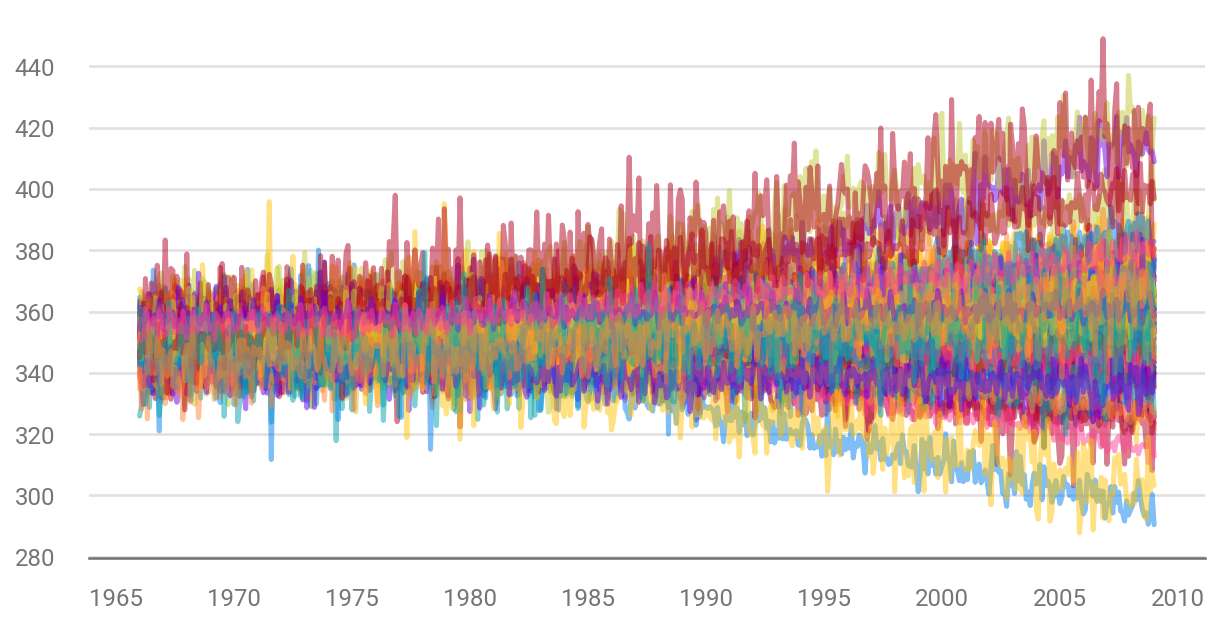

In [47]:
# Generate trend design matrix
n_changepoints = 12
n_tp = seasonality_all.shape[0]
t = np.linspace(0, 1, n_tp, dtype=np.float32)
s = np.linspace(0, max(t), n_changepoints + 2, dtype=np.float32)[1:-1]
A = (t[:, None] > s).astype(np.float32)
# Generate seasonality design matrix
# Set n=6 here so that there are 12 columns (same as `seasonality_all`)
X_pred = gen_fourier_basis(
    np.where(seasonality_all)[1], p=seasonality_all.shape[-1], n=6
)
n_pred = X_pred.shape[-1]


def gen_gam_jd(training=True):
    @tfd.JointDistributionCoroutine
    def gam():
        beta = yield root(
            tfd.Sample(tfd.Normal(0.0, 1.0), sample_shape=n_pred, name="beta")
        )
        seasonality = tf.einsum("ij,...j->...i", X_pred, beta)

        k = yield root(tfd.HalfNormal(10.0, name="k"))
        m = yield root(
            tfd.Normal(co2_by_month_training_data["CO2"].mean(), scale=5.0, name="m")
        )
        tau = yield root(tfd.HalfNormal(10.0, name="tau"))
        delta = yield tfd.Sample(
            tfd.Laplace(0.0, tau), sample_shape=n_changepoints, name="delta"
        )

        growth_rate = k[..., None] + tf.einsum("ij,...j->...i", A, delta)
        offset = m[..., None] + tf.einsum("ij,...j->...i", A, -s * delta)
        trend = growth_rate * t + offset

        y_hat = seasonality + trend
        if training:
            y_hat = y_hat[..., : co2_by_month_training_data.shape[0]]

        noise_sigma = yield root(tfd.HalfNormal(scale=5.0, name="noise_sigma"))
        observed = yield tfd.Independent(
            tfd.Normal(y_hat, noise_sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name="observed",
        )
    return gam


prior_samples = gen_gam_jd().sample(100)
prior_predictive_timeseries = prior_samples[-1]
_, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    co2_by_month.index[:-num_forecast_steps],
    tf.transpose(prior_predictive_timeseries),
    alpha=0.5,
);

2022-05-31 19:59:12.064139: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


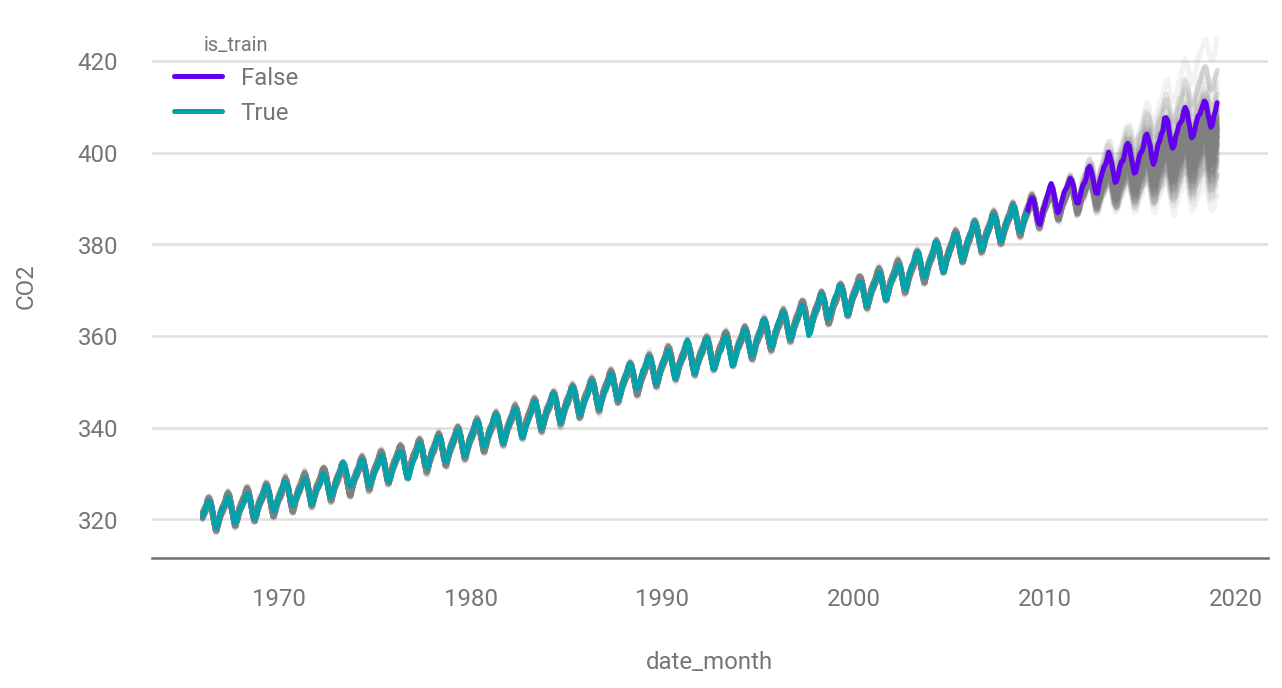

In [48]:
run_mcmc = tf.function(
    tfp.experimental.mcmc.windowed_adaptive_nuts, autograph=False, jit_compile=True
)

mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    gam,
    n_chains=4,
    num_adaptation_steps=1_000,
    seed=tf.constant([-12341, 62345], dtype=tf.int32),
    observed=co2_by_month_training_data.T,
)
gam_idata = az.from_dict(
    posterior={
        k: np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)
gam_full = gen_gam_jd(training=False)
posterior_dists, _ = gam_full.sample_distributions(value=mcmc_samples)

_, ax = plt.subplots(figsize=(10, 5))
fitted_with_forecast = posterior_dists[-1].distribution.sample().numpy()
ax.plot(
    co2_by_month.index, fitted_with_forecast[-100:, 0, :].T, color="gray", alpha=0.1
)
ax.plot(
    co2_by_month.index, fitted_with_forecast[-100:, 1, :].T, color="gray", alpha=0.1
)
(
    co2_by_month.assign(
        is_train=lambda df: df.index.isin(co2_by_month.iloc[:-num_forecast_steps].index)
    )
    .reset_index()
    .pipe((sns.lineplot, "data"), x="date_month", y="CO2", hue="is_train", ax=ax)
);

Here we used linear trend from last period for forecasting.
But it's recommended that at each point
we first determine whether that time point would be a change point,
with a probability proportional ot the number of predefined change points divided by the total number of observations,
and then generate a new delta
from the posterior distribution $\delta_{new} \sim \text{Laplace}(0, \tau)$.

## Autoregressive models

Time series has a sequential dependency of the observations.
This usually introduces structured errors that are correlated temporally
on previous observations or errors—
like autoregressive-ness.
In autoregressive model
the distribution of output at time $t$
is parameterized by a linear function of previous observations.

$$
y_t \sim \mathcal{N}(\alpha + \rho y_{t-1}, \sigma)
$$

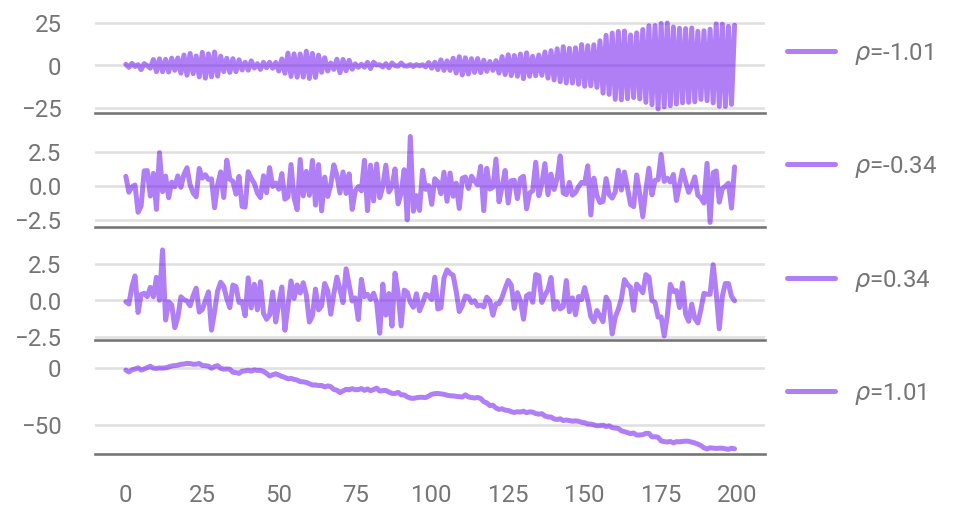

In [49]:
n_t = 200


@tfd.JointDistributionCoroutine
def ar1_with_forloop():
    sigma = yield root(tfd.HalfNormal(1.0))
    rho = yield root(tfd.Uniform(-1.0, 1.0))
    x0 = yield tfd.Normal(0.0, sigma)
    x = [x0]
    for i in range(1, n_t):
        x_i = yield tfd.Normal(x[i - 1] * rho, sigma)
        x.append(x_i)


nplot = 4
_, axes = plt.subplots(nplot, 1)
for ax, rho in zip(axes, np.linspace(-1.01, 1.01, nplot)):
    test_samples = ar1_with_forloop.sample(value=(1.0, rho))
    ar1_samples = tf.stack(test_samples[2:])
    ax.plot(ar1_samples, alpha=0.5, label=r"$\rho$=%.2f" % rho)
    ax.legend(bbox_to_anchor=(1, 1), loc="upper left")

As seen above,
AR(1) process is not stationary when $\mid \rho \mid > 1$.

We can rewrite this without a for-loop by using `tfd.Autoregressive`.
It only retains the end state of the process.
To get all steps,
we can express the autoregressive equation with a backshift
(or Lag)
operator $\mathbf{B}$
that shift the time series $\mathbf{B}y_t = y_{t - 1}$.
So we have $Y \sim \mathcal{N}(\rho \mathbf{B} Y, \sigma)$.

In [50]:
@tfd.JointDistributionCoroutine
def ar1_without_forloop():
    sigma = yield root(tfd.HalfNormal(1.0))
    rho = yield root(tfd.Uniform(-1.0, 1.0))

    def ar1_fun(x):
        # We apply the backshift operation here
        x_tm1 = tf.concat([tf.zeros_like(x[..., :1]), x[..., :-1]], axis=-1)
        loc = x_tm1 * rho[..., None]
        return tfd.Independent(
            tfd.Normal(loc=loc, scale=sigma[..., None]),
            reinterpreted_batch_ndims=1,
        )

    dist = yield tfd.Autoregressive(
        distribution_fn=ar1_fun,
        sample0=tf.zeros([n_t], dtype=rho.dtype),
        num_steps=n_t,
    )

2022-05-31 20:00:28.991639: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


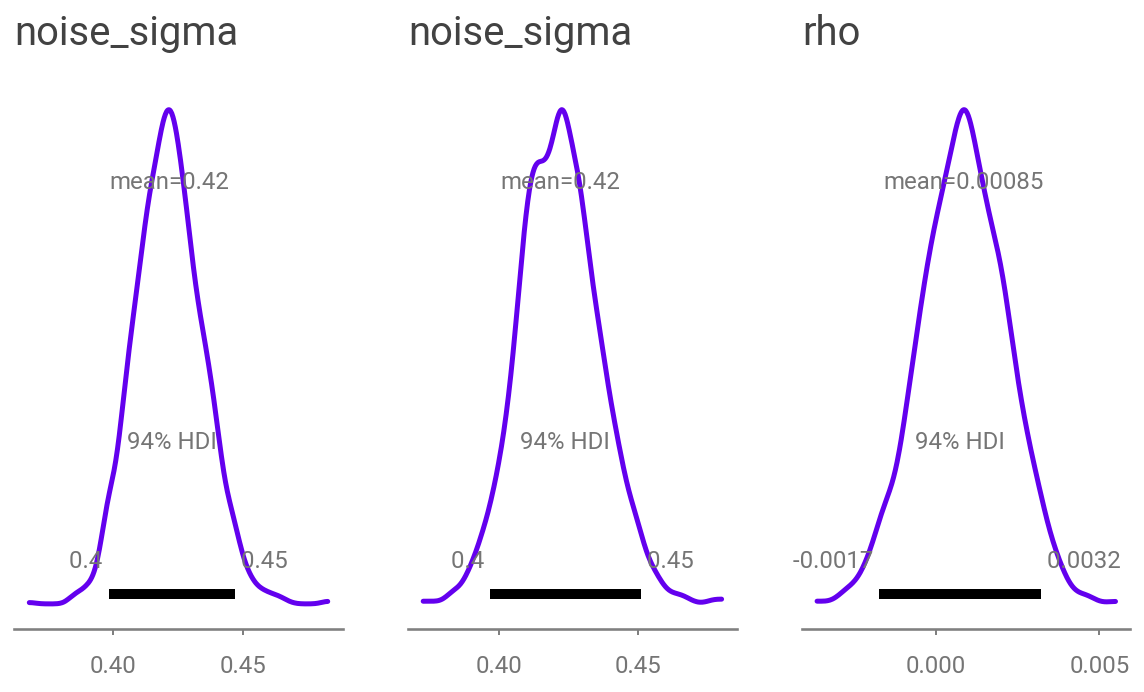

In [51]:
def gam_trend_seasonality():
    beta = yield root(
        tfd.Sample(tfd.Normal(0.0, 1.0), sample_shape=n_pred, name="beta")
    )
    seasonality = tf.einsum("ij,...j->...i", X_pred, beta)

    k = yield root(tfd.HalfNormal(10.0, name="k"))
    m = yield root(
        tfd.Normal(co2_by_month_training_data["CO2"].mean(), scale=5.0, name="m")
    )
    tau = yield root(tfd.HalfNormal(10.0, name="tau"))
    delta = yield tfd.Sample(
        tfd.Laplace(0.0, tau), sample_shape=n_changepoints, name="delta"
    )

    growth_rate = k[..., None] + tf.einsum("ij,...j->...i", A, delta)
    offset = m[..., None] + tf.einsum("ij,...j->...i", A, -s * delta)
    trend = growth_rate * t + offset
    noise_sigma = yield root(tfd.HalfNormal(scale=5.0, name="noise_sigma"))
    return seasonality, trend, noise_sigma


def generate_gam(training=True):
    @tfd.JointDistributionCoroutine
    def gam():
        seasonality, trend, noise_sigma = yield from gam_trend_seasonality()
        y_hat = seasonality + trend
        if training:
            y_hat = y_hat[..., : co2_by_month_training_data.shape[0]]

        # likelihood
        observed = yield tfd.Independent(
            tfd.Normal(y_hat, noise_sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name="observed",
        )

    return gam


gam = generate_gam()


def generate_gam_ar_likelihood(training=True):
    @tfd.JointDistributionCoroutine
    def gam_with_ar_likelihood():
        seasonality, trend, noise_sigma = yield from gam_trend_seasonality()
        y_hat = seasonality + trend
        if training:
            y_hat = y_hat[..., : co2_by_month_training_data.shape[0]]

        # Likelihood
        rho = yield root(tfd.Uniform(-1.0, 1.0, name="rho"))

        def ar_fun(y):
            loc = (
                tf.concat([tf.zeros_like(y[..., :1]), y[..., :-1]], axis=-1)
                * rho[..., None]
                + y_hat
            )
            return tfd.Independent(
                tfd.Normal(loc=loc, scale=noise_sigma[..., None]),
                reinterpreted_batch_ndims=1,
            )

        observed = yield tfd.Autoregressive(
            distribution_fn=ar_fun,
            sample0=tf.zeros_like(y_hat),
            num_steps=1,
            name="observed",
        )

    return gam_with_ar_likelihood


gam_with_ar_likelihood = generate_gam_ar_likelihood()


def generate_gam_ar_likelihood(training=True):
    @tfd.JointDistributionCoroutine
    def gam_with_ar_likelihood():
        seasonality, trend, noise_sigma = yield from gam_trend_seasonality()
        y_hat = seasonality + trend
        if training:
            y_hat = y_hat[..., : co2_by_month_training_data.shape[0]]

        # Likelihood
        rho = yield root(tfd.Uniform(-1.0, 1.0, name="rho"))

        def ar_fun(y):
            loc = (
                tf.concat([tf.zeros_like(y[..., :1]), y[..., :-1]], axis=-1)
                * rho[..., None]
                + y_hat
            )
            return tfd.Independent(
                tfd.Normal(loc=loc, scale=noise_sigma[..., None]),
                reinterpreted_batch_ndims=1,
            )

        observed = yield tfd.Autoregressive(
            distribution_fn=ar_fun,
            sample0=tf.zeros_like(y_hat),
            num_steps=1,
            name="observed",
        )

    return gam_with_ar_likelihood


gam_with_ar_likelihood = generate_gam_ar_likelihood()

mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    gam_with_ar_likelihood,
    n_chains=4,
    num_adaptation_steps=1_000,
    seed=tf.constant([-234272345, 73564234], dtype=tf.int32),
    observed=co2_by_month_training_data.T,
)
gam_ar_likelihood_idata = az.from_dict(
    posterior={
        k: np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)


_, axes = plt.subplots(1, 3, figsize=(10, 5))
az.plot_posterior(gam_idata, var_names=["noise_sigma"], ax=axes[0])
az.plot_posterior(
    gam_ar_likelihood_idata, var_names=["noise_sigma", "rho"], ax=axes[1:]
);

Instead of using an AR(k) likelihood,
can also include AR in a timer series by adding a latent AR component.

In [52]:
def generate_gam_ar_latent(training=True):
    @tfd.JointDistributionCoroutine
    def gam_with_latent_ar():
        seasonality, trend, noise_sigma = yield from gam_trend_seasonality()

        # Latent AR(1)
        ar_sigma = yield root(tfd.HalfNormal(0.1, name="ar_sigma"))
        rho = yield root(tfd.Uniform(-1.0, 1.0, name="rho"))

        def ar_fun(y):
            loc = (
                tf.concat([tf.zeros_like(y[..., :1]), y[..., :-1]], axis=-1)
                * rho[..., None]
            )
            return tfd.Independent(
                tfd.Normal(loc=loc, scale=ar_sigma[..., None]),
                reinterpreted_batch_ndims=1,
            )

        temporal_error = yield tfd.Autoregressive(
            distribution_fn=ar_fun,
            sample0=tf.zeros_like(trend),
            num_steps=trend.shape[-1],
            name="temporal_error",
        )

        # Linear prediction
        y_hat = seasonality + trend + temporal_error
        if training:
            y_hat = y_hat[..., : co2_by_month_training_data.shape[0]]

        # Likelihood
        observed = yield tfd.Independent(
            tfd.Normal(y_hat, noise_sigma[..., None]),
            reinterpreted_batch_ndims=1,
            name="observed",
        )

    return gam_with_latent_ar


gam_with_latent_ar = generate_gam_ar_latent()

mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    gam_with_latent_ar,
    n_chains=4,
    num_adaptation_steps=1_000,
    seed=tf.constant([36245, 734565], dtype=tf.int32),
    observed=co2_by_month_training_data.T,
)
nuts_trace_ar_latent = az.from_dict(
    posterior={
        k: np.swapaxes(v.numpy(), 1, 0) for k, v in mcmc_samples._asdict().items()
    },
    sample_stats={
        k: np.swapaxes(sampler_stats[k], 1, 0)
        for k in ["target_log_prob", "diverging", "accept_ratio", "n_steps"]
    },
)


2022-05-31 20:03:21.845120: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:38] Ignoring Assert operator mcmc_retry_init/assert_equal_1/Assert/AssertGuard/Assert


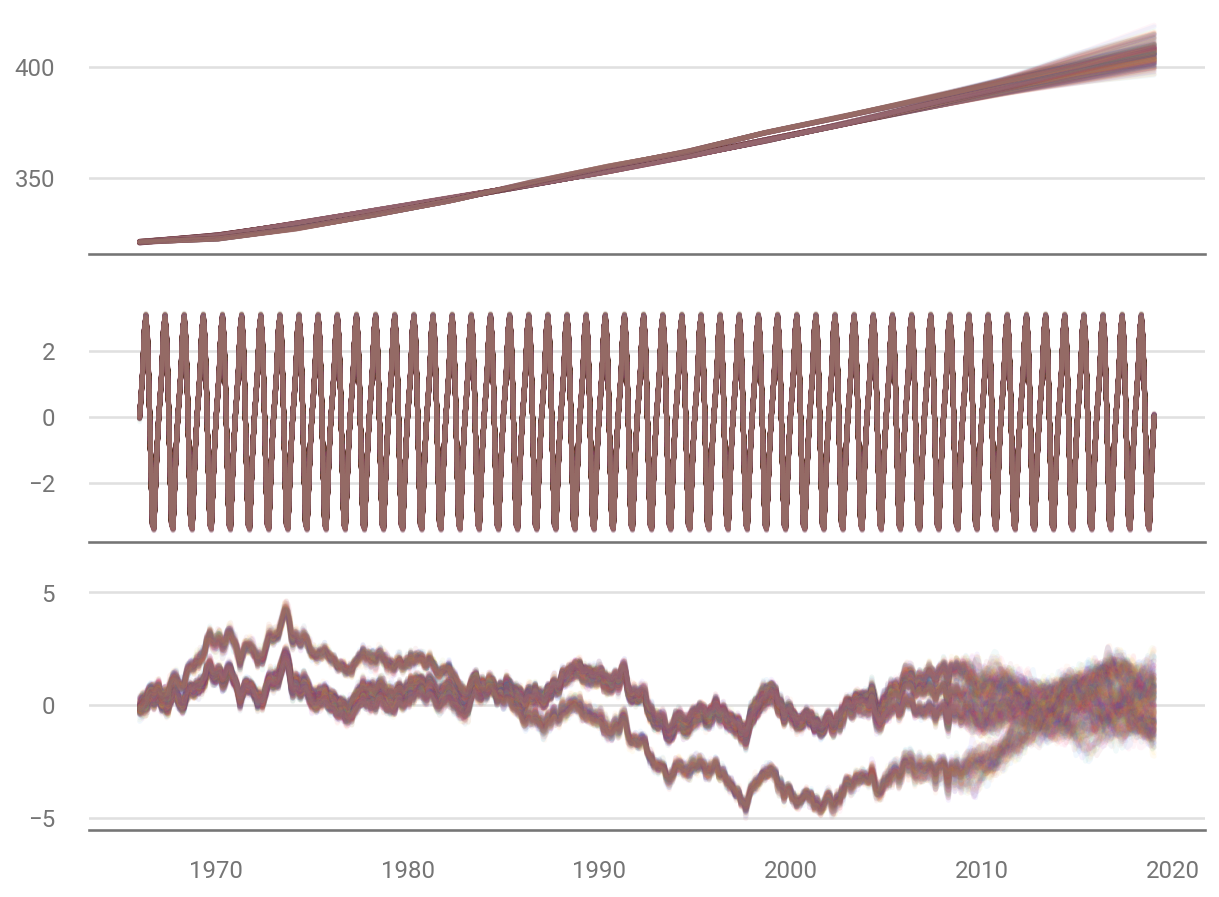

In [53]:
_, ax = plt.subplots(3, 1, figsize=(10, 7.5), sharex=True)
beta, k, m, tau, delta = mcmc_samples[:5]
growth_rate = k[..., None] + tf.einsum("ij,...j->...i", A, delta)
offset = m[..., None] + tf.einsum("ij,...j->...i", A, -s * delta)
trend_posterior = growth_rate * t + offset
seasonality_posterior = tf.einsum("ij,...j->...i", X_pred, beta)
temporal_error = mcmc_samples[-1]
for i in range(nchains):
    ax[0].plot(co2_by_month.index, trend_posterior[-100:, i, :].numpy().T, alpha=0.05)
    ax[1].plot(
        co2_by_month.index, seasonality_posterior[-100:, i, :].numpy().T, alpha=0.05
    )
    ax[2].plot(co2_by_month.index, temporal_error[-100:, i, :].numpy().T, alpha=0.05)

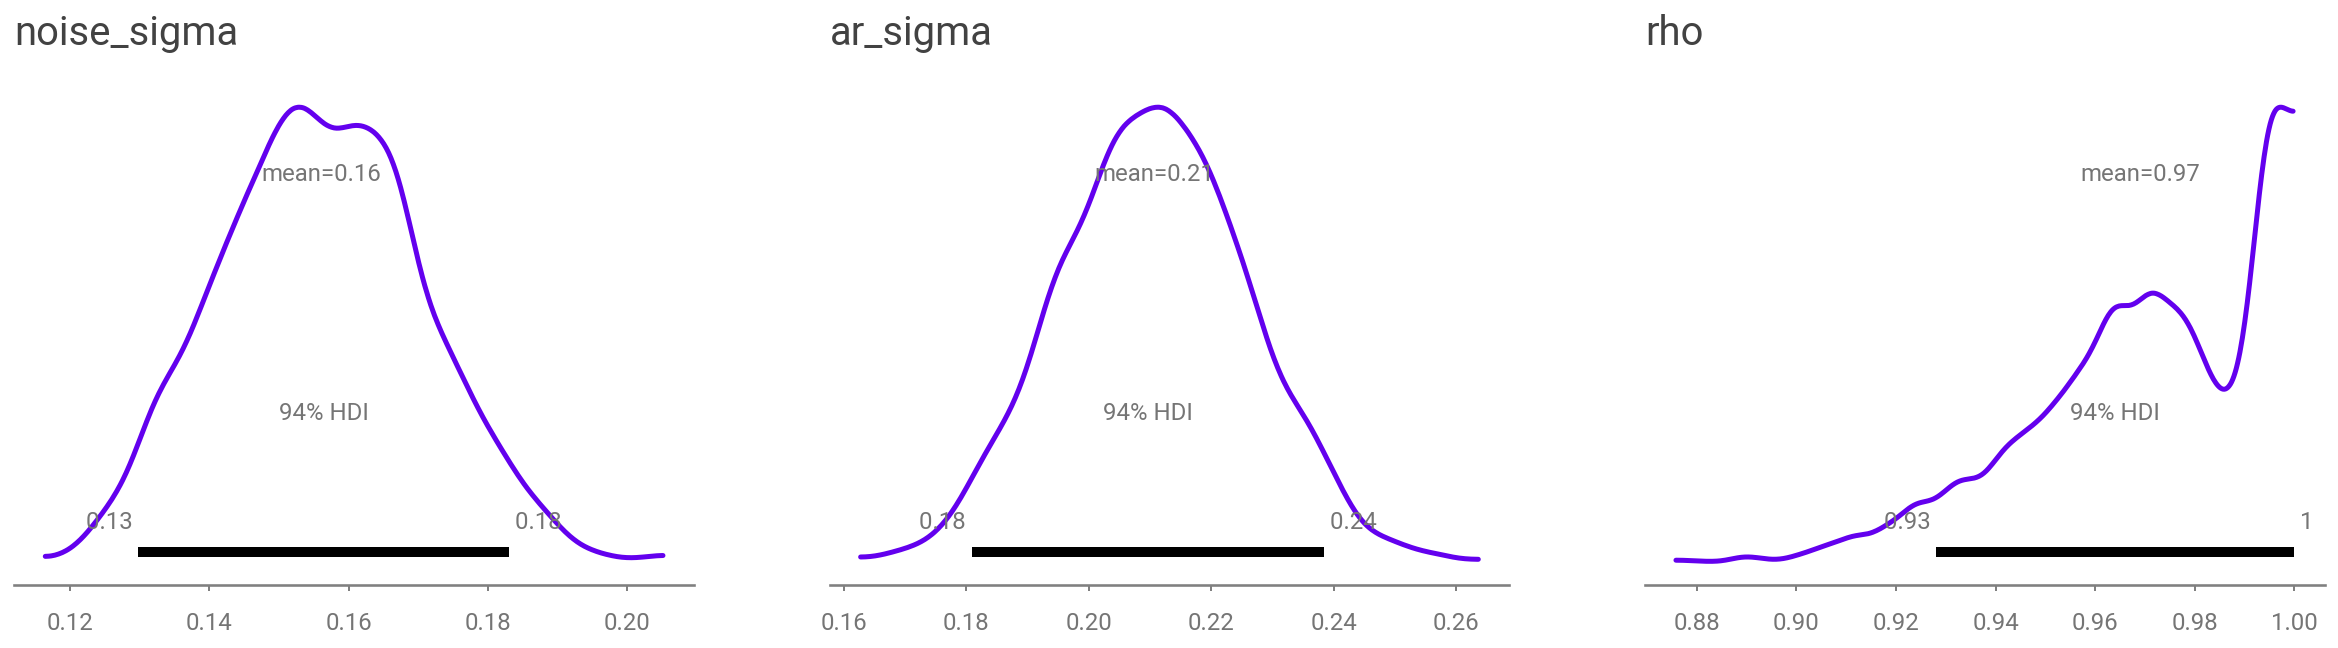

In [55]:
az.plot_posterior(nuts_trace_ar_latent, var_names=["noise_sigma", "ar_sigma", "rho"]);

### Latent AR process and smoothing

The latent process can approximate some arbitrary functions.
Consider a time series witth a latent GRW component AR(1) process with $\rho = 1$:

$$
\begin{split}
z_i & \sim \mathcal{N}(z_{i-1}, \sigma_{z}^2) \: \text{ for } i=1,\dots,N \\
y_i & \sim \mathcal{N}(z_i,  \sigma_{y}^2)
\end{split}
$$

By placing a different prior on $\sigma_z$ and $\sigma_y$
we can emphasize how much of the variance in the observed data
should be accounted for in the GRW
and how much is noise.
We can rewrite the above as:

$$
\begin{split}
z_i & \sim \mathcal{N}(z_{i-1}, (1 - \alpha) \sigma^2) \: \text{ for } i=1,\dots,N \\
y_i & \sim \mathcal{N}(z_i,   \alpha \sigma^2)
\end{split}
$$

where:

$$
\alpha = \frac{\sigma_{y}^2}{\sigma_{z}^2 + \sigma_{y}^2}
$$

$\alpha$  is the degree of smoothing
in the range of $[0, 1]$.
By placing an informative prior on $\alpha$,
we can control how much smoothing we would like to see in the latent GRW—larger
$\alpha$ is smoother.

2022-06-01 08:37:16.074845: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-06-01 08:37:16.075010: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-06-01 08:37:16.097477: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-06-01 08:37:16.097529: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-06-01 08:37:16.112396: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-06-01 08:37:16.112457: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at functional_ops.cc:374 : INTERNAL: No function library
2022-06-01 08:37:16.148831: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed 

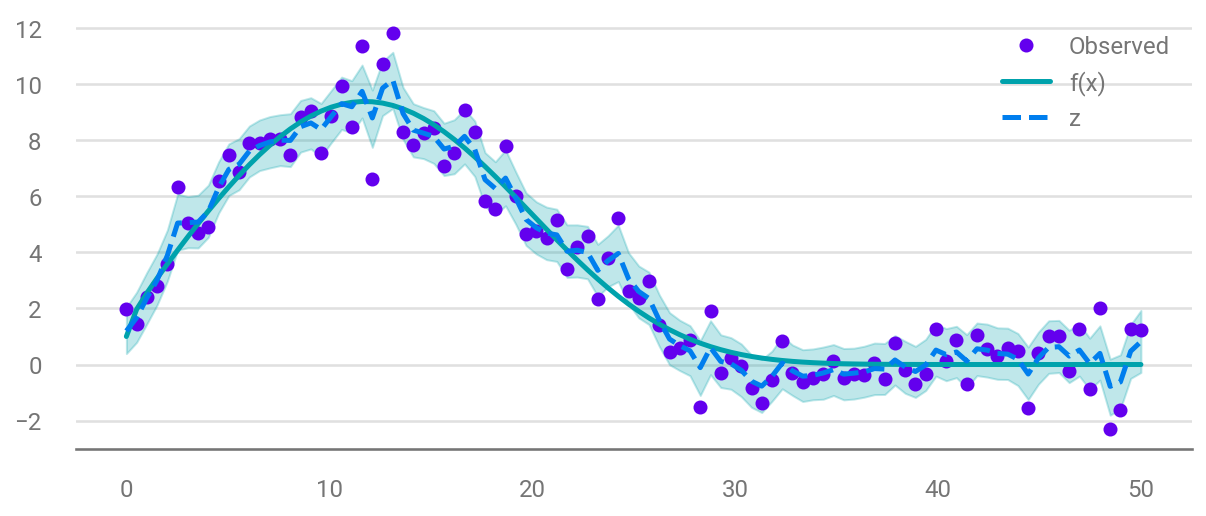

In [60]:
num_steps = 100
x = np.linspace(0, 50, num_steps)
f = np.exp(1.0 + np.power(x, 0.5) - np.exp(x / 15.0))
y = f + np.random.normal(scale=1.0, size=x.shape)


@tfd.JointDistributionCoroutine
def smoothing_grw():
    alpha = yield root(tfd.Beta(5, 1.0))
    variance = yield root(tfd.HalfNormal(10.0))
    sigma0 = tf.sqrt(variance * alpha)
    sigma1 = tf.sqrt(variance * (1.0 - alpha))
    z = yield tfd.Sample(tfd.Normal(0.0, sigma0), num_steps)
    observed = yield tfd.Independent(
        tfd.Normal(tf.math.cumsum(z, axis=-1), sigma1[..., None]),
        name="observed",
    )


mcmc_samples, sampler_stats = run_mcmc(
    1_000,
    smoothing_grw,
    n_chains=4,
    num_adaptation_steps=1_000,
    observed=tf.constant(y[None, ...], dtype=tf.float32),
)
nsample, nchain = mcmc_samples[-1].shape[:2]
z = tf.reshape(tf.math.cumsum(mcmc_samples[-1], axis=-1), [nsample * nchain, -1])
lower, upper = np.percentile(z, [5, 95], axis=0)

_, ax = plt.subplots(figsize=(10, 4))
ax.plot(x, y, "o", label="Observed")
ax.plot(x, f, label="f(x)")
ax.fill_between(x, lower, upper, color="C1", alpha=0.25)
ax.plot(x, tf.reduce_mean(z, axis=0), color="C4", ls="--", label="z")
ax.legend();

It might be that the autoregression model alone is useless to capture the long-term trend.
Even if it fits well in the observtion,
during forecast it will quickly regress to the mean of the last few steps—the
same as a Gaussian Process with a constant mean function.

An autoregressive component as an additional trend component
could place some challenges to model inference.
Scaling can be an issue—since
we are addint a random variable with the same shape as the observed time series.
We might have an unidentificable model
when both the trend component and the AR process are flexible,
since the AR process alone has the ability to approximate the underlying trend.